## Demo for Santander Product Recommendation Project
#### Part 1: Data loading and cleaning
This is the work demo for Satandander Product Recommendation Project, which is a also Kaggle Contest. We ranked as 12nd in Public LB and 16th in Private LB. In this project the target was to recommend new products to customers based on their historical behavioral patterns, product purchase records as well as demographic information. The demo will give a step-by-step workflow of my work. Basically this notebook includes:
- Data cleaning and filtering
- Feature Engineer
- EDA and feature exploration
- Model Training and Validation

**Note:** *We only use training data for the demonstration and validation as the true label was not provided in test data*


In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import helper.data
reload(helper.data)

<module 'helper.data' from 'helper/data.pyc'>

In [4]:
## disable warnings
import warnings

warnings.filterwarnings('ignore')

In [ ]:
config_db = "../input/santander_full.sqlite"

#### 0. Import necessary modules

In [5]:
import pandas as pd
import sqlite3 as sq
import numpy as np
import datetime
import gc
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
sq_conn = sq.connect(config_db)

Populating the interactive namespace from numpy and matplotlib


#### 1. Load Train Data

- Load data from local file


In [6]:
## Read train data from file (I translated all Spanish col names into English)
from helper.data import load_data
file_path = "../input/train_ver2.csv.zip"
df_train = load_data(file_path)

In [8]:
print df_train.shape
df_train.head()

(13647309, 48)


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


- Translate data columns into English

In [9]:
# Translate the data column names into English for better explanation
from helper.data import set_rename
map_rename = set_rename()
df_train.rename(columns=map_rename, inplace = True)

In [10]:
df_train.head()

,date_record,cust_id,idx_employee,country_code,sex,age,date_first_holder,idx_new_cust,months_seniority,idx_primary,...,p15_mortgage,p16_pensions_plan,p17_loans,p18_taxes,p19_credit_card,p20_securities,p21_home_acct,p22_payroll_appt,p23_pensions_appt,p24_direct_debit
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050611,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050612,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050613,N,ES,H,22,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050614,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


### Select a sample by cust_id

In [219]:
# There are 956645 unique cust_ids in total, we select 100000 unique users 
N = 100000
np.random.seed(2017)
rand_cust_ids = np.random.choice(list(set(df_train.cust_id)), N, replace=False)
df_select_cust = pd.DataFrame({"cust_id": rand_cust_ids.tolist(), "issample": [1] * N})

In [220]:
# join df_select_cust onto df_train and keep only items with issample == 1
df_train = df_train.merge(df_select_cust, how = "left", on = "cust_id")

In [221]:
df = df_train.loc[df_train.issample == 1, :]

In [222]:
df.reset_index(drop = True, inplace = True)
df.drop(["issample"], axis = 1, inplace = True)

In [223]:
# (1427491, 48)
df.head()

,date_record,cust_id,idx_employee,country_code,sex,age,date_first_holder,idx_new_cust,months_seniority,idx_primary,...,p15_mortgage,p16_pensions_plan,p17_loans,p18_taxes,p19_credit_card,p20_securities,p21_home_acct,p22_payroll_appt,p23_pensions_appt,p24_direct_debit
0,2015-01-28,1375586,N,ES,H,35,2015-01-12,0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050614,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050610,N,ES,V,24,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050582,N,ES,V,28,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050591,N,ES,H,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


#### 2. Clean data and impute missing values

- Convert date_record to months passed after 2015-01-28

In [16]:
from helper.data import conv_to_mon
df["date_record"] = df["date_record"].apply(conv_to_mon)

In [17]:
df.head()

,date_record,cust_id,idx_employee,country_code,sex,age,date_first_holder,idx_new_cust,months_seniority,idx_primary,...,p15_mortgage,p16_pensions_plan,p17_loans,p18_taxes,p19_credit_card,p20_securities,p21_home_acct,p22_payroll_appt,p23_pensions_appt,p24_direct_debit
0,0,1375586,N,ES,H,35,2015-01-12,0,6,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,0,1050611,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,0,1050612,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,0,1050613,N,ES,H,22,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,0,1050614,N,ES,V,23,2012-08-10,0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [18]:
df.tail()

,date_record,cust_id,idx_employee,country_code,sex,age,date_first_holder,idx_new_cust,months_seniority,idx_primary,...,p15_mortgage,p16_pensions_plan,p17_loans,p18_taxes,p19_credit_card,p20_securities,p21_home_acct,p22_payroll_appt,p23_pensions_appt,p24_direct_debit
13647304,16,1166765,N,ES,V,22,2013-08-14,0,33,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
13647305,16,1166764,N,ES,V,23,2013-08-14,0,33,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
13647306,16,1166763,N,ES,H,47,2013-08-14,0,33,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
13647307,16,1166789,N,ES,H,22,2013-08-14,0,33,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
13647308,16,1550586,N,ES,H,37,2016-05-13,1,0,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


- Add a column "month" to indicate natural month number each year

In [19]:
df.loc[:,"month"] = (df.date_record)%12 + 1

- initial clean up: remove space before/after strings

In [20]:
## clean string
def clean_entry(x):
    """
    normalize each entry into compact dtype
    """
    if pd.isnull(x):
        return None
    res = str(x).strip()
    if res == '':
        return None
    try:
        res = str(int(float(res)))
    except:
        res = res.strip()
    return res
    

In [21]:
#df.loc[:, "months_seniority"] = df.loc[:, "months_seniority"].apply(lambda x: clean_entry(x, dtype = "str"))

In [22]:
#df.months_seniority.unique()

In [24]:
## clean each column of df
cols_int = ["age", "months_seniority", "p1_saving_acct", "p2_guarantees", "p3_cur_acct", "p4_deriv_acct", 
"p5_payroll_acct", "p6_junior_acct", "p7_mas_paticular_acct", "p8_particular_acct", "p9_particular_plus_acct", "p10_short_depo", 
            "p11_medium_depo", "p12_long_depo", "p13_eacct", "p14_funds", "p15_mortgage", "p16_pensions_plan", "p17_loans", 
            "p18_taxes", "p19_credit_card", "p20_securities", "p21_home_acct", "p22_payroll_appt", "p23_pensions_appt", "p24_direct_debit"]
cols_float = ["income"]
cols_str = ["idx_employee", "country_code", "sex", "date_first_holder", "idx_new_cust", "idx_primary", "date_last_primary", "type_cust", 
"type_cust_relation", "idx_same_country", "idx_foreigner", "idx_spouse", "channel", "idx_decease", "type_addr", "prov_code", "prov_name", 
"idx_active", "segmentation"]

for col in cols_int + cols_float + cols_str: 
    print "processing: ", col
    try:
        df.loc[:, col] = df.loc[:, col].apply(lambda x: clean_entry(x))
    except:
        print "error ", col, df.loc[:, col].unique()
        
for col in df.columns:
    print col, df.loc[:, col].unique()


 processing:  age
processing:  months_seniority
processing:  p1_saving_acct
processing:  p2_guarantees
processing:  p3_cur_acct
processing:  p4_deriv_acct
processing:  p5_payroll_acct
processing:  p6_junior_acct
processing:  p7_mas_paticular_acct
processing:  p8_particular_acct
processing:  p9_particular_plus_acct
processing:  p10_short_depo
processing:  p11_medium_depo
processing:  p12_long_depo
processing:  p13_eacct
processing:  p14_funds
processing:  p15_mortgage
processing:  p16_pensions_plan
processing:  p17_loans
processing:  p18_taxes
processing:  p19_credit_card
processing:  p20_securities
processing:  p21_home_acct
processing:  p22_payroll_appt
processing:  p23_pensions_appt
processing:  p24_direct_debit
processing:  income
processing:  idx_employee
processing:  country_code
processing:  sex
processing:  date_first_holder
processing:  idx_new_cust
processing:  idx_primary
processing:  date_last_primary
processing:  type_cust
processing:  type_cust_relation
processing:  idx_sa

In [25]:
## post cleaning
#### Age, product, months_seniority, income into integer
def clean_int(x):
    if pd.isnull(x):
        res = None
    elif x == "NA" or x == "-999999":
        res = None
    else:
        try:
            res = int(float(x))
        except:
            res = None
    return res
        

In [26]:
for col in ["age", "months_seniority", "income"]:    
    df.loc[:, col] = df.loc[:, col].apply(lambda x: clean_int(x))

- Convert numerical columns into numeric type

In [28]:
# age, months_seniority and income
cols_numerical = ["age", "months_seniority", "income"]
for col in cols_numerical:
    df[col] = pd.to_numeric(df[col], errors = "coerce")


#### Impute Missing Values
- Check which columns contains missing values

In [33]:
for col in df.columns:
    print col, df.loc[:, col].isnull().sum()

date_record 0
cust_id 0
idx_employee 27734
country_code 27734
sex 27804
age 27734
date_first_holder 27734
idx_new_cust 27734
months_seniority 27772
idx_primary 27734
date_last_primary 13622516
type_cust 149781
type_cust_relation 149781
idx_same_country 27734
idx_foreigner 27734
idx_spouse 13645501
channel 186126
idx_decease 27734
type_addr 27735
prov_code 93591
prov_name 93591
idx_active 27734
income 2794375
segmentation 189368
p1_saving_acct 0
p2_guarantees 0
p3_cur_acct 0
p4_deriv_acct 0
p5_payroll_acct 0
p6_junior_acct 0
p7_mas_paticular_acct 0
p8_particular_acct 0
p9_particular_plus_acct 0
p10_short_depo 0
p11_medium_depo 0
p12_long_depo 0
p13_eacct 0
p14_funds 0
p15_mortgage 0
p16_pensions_plan 0
p17_loans 0
p18_taxes 0
p19_credit_card 0
p20_securities 0
p21_home_acct 0
p22_payroll_appt 16063
p23_pensions_appt 16063
p24_direct_debit 0
month 0


- "age" filled with median and correct out-of-bound ages

In [34]:
df["age"].isnull().sum()

27734

In [35]:
df["age"].fillna(df["age"].median(), inplace=True)
# if age < 0 or age > 200, correct it to closest bound
df.loc[df.age < 0,"age"]  = 0
df.loc[df.age > 200,"age"]  = 200

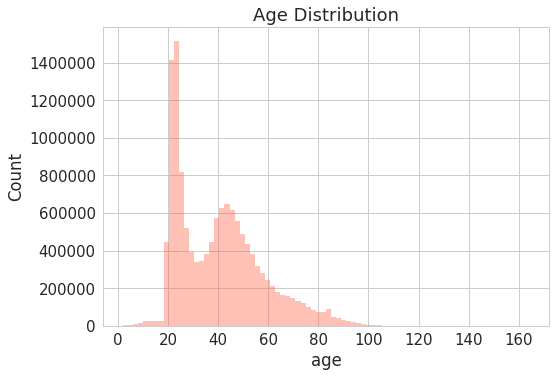

In [36]:
## check age distribution
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df["age"].dropna(),
                 bins=80,
                 kde=False,
                 color="tomato")
    sns.plt.title("Age Distribution")
    plt.ylabel("Count")

- "idx_new_cust" which indicates whether a customer is new or not

In [59]:
print df["idx_new_cust"].isnull().sum()
print df["idx_new_cust"].unique()

0
['0' '1']


In [54]:
df.index[df.loc[:, "idx_new_cust"].isnull()]

Int64Index([    261,    1029,    1063,    1154,    1779,    1850,    1867,
               1886,    1922,    2142,
            ...
            3774902, 3775205, 3775245, 3775860, 3775909, 3775976, 3776175,
            3776230, 3776279, 3776332],
           dtype='int64', length=27734)

In [56]:
months_active_missing = df.loc[df.index[df.loc[:, "idx_new_cust"].isnull()], ["idx_new_cust", "cust_id"]].groupby("cust_id", sort=False).size()
months_active_0 = df.loc[df.index[df["idx_new_cust"]=='0'],["idx_new_cust", "cust_id"]].groupby("cust_id", sort=False).size()
months_active_1 = df.loc[df.index[df["idx_new_cust"]=='1'],["idx_new_cust", "cust_id"]].groupby("cust_id", sort=False).size()

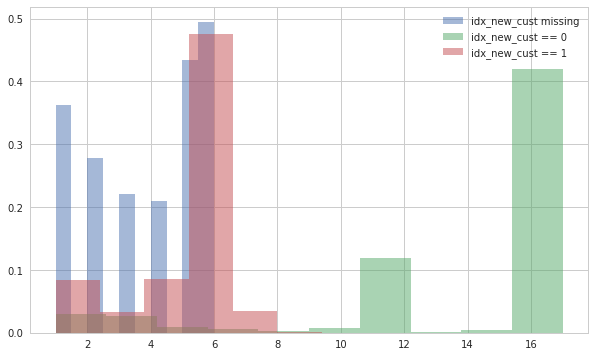

In [57]:
## visual which group is the missing group similar to? 
plt.hist(months_active_missing, alpha=0.5, normed=1, label='idx_new_cust missing')
plt.hist(months_active_0, alpha=0.5, normed=1, label='idx_new_cust == 0')
plt.hist(months_active_1, alpha=0.5, normed=1, label='idx_new_cust == 1')
plt.legend(loc='upper right')
plt.show()

In [58]:
## Therefore fill missing idx_new_cust with 1
df.loc[df["idx_new_cust"].isnull(),"idx_new_cust"] = '1'

- months_seniority

In [62]:
print df["months_seniority"].isnull().sum()
print df["months_seniority"].unique()

0
[   6.   35.   34.    0.   33.   31.   21.   16.   27.    9.   22.   13.
   29.    8.   11.   10.   28.   24.    7.   25.   14.   26.   12.   23.
    1.   18.    4.    3.   17.   32.   30.   20.   15.   19.  157.   36.
    5.   40.   38.   37.   39.    2.   47.   44.   42.   46.   45.   43.
   41.   57.   48.   52.   49.   50.   56.   58.   51.   55.   54.   53.
   59.   62.   61.   60.   63.  139.  165.  118.  164.  142.   94.  159.
  143.  105.  151.  162.  137.  150.  128.  122.  156.  119.  160.   79.
   95.  132.  161.   98.  127.   72.  155.  108.  163.  102.  148.  115.
  146.  107.   81.  216.  135.   92.  121.  198.  134.   93.  140.  110.
  120.  147.  116.   64.   77.   85.   99.   78.  100.  113.  154.  166.
  133.  124.  141.   66.  117.   86.  193.   80.  144.   87.  126.  158.
  101.  235.   88.  145.  103.  149.  109.  131.   97.   68.   84.  232.
  125.  177.  112.   96.   69.  171.  167.  104.   76.   82.  152.   70.
  138.  169.   65.  129.  190.  114.  111.  176. 

In [61]:
# fill min value to missing
df.loc[df.months_seniority.isnull(),"months_seniority"] = df.months_seniority.min()

- date_first_holder 

In [65]:
print df["date_first_holder"].isnull().sum()
print df["date_first_holder"].unique()

0
['2015-01-12' '2012-08-10' '2011-09-06' ..., '2016-05-25' '2016-05-01'
 '2016-05-15']


In [64]:
## fill with median as there is no other information
dates=df.loc[:,"date_first_holder"].sort_values().reset_index()
median_date = int(np.median(dates.index.values))
df.loc[df.date_first_holder.isnull(),"date_first_holder"] = dates.loc[median_date,"date_first_holder"]

- idx_primary

In [68]:
print df["idx_primary"].isnull().sum()
print df["idx_primary"].unique()

0
['1' '99']


In [67]:
## fill missing with 1
df.loc[df.idx_primary.isnull(),"idx_primary"] = '1'

- drop type_addr and prov_code as they are useless
- type_addr only contains one value and prov_name is used instead of prov_code

In [69]:
print df["type_addr"].isnull().sum()
print df["type_addr"].unique()

27735
['1' None]


In [70]:
df.drop(["type_addr","prov_code"],axis=1,inplace=True)

- idx_active 

In [71]:
print df["idx_active"].isnull().sum()
print df["idx_active"].unique()

27734
['1' '0' None]


In [72]:
df.loc[:, "idx_active"].apply(lambda x: int(x) if x != None else None).median()

0.0

In [73]:
## fill with median
df.loc[df.idx_active.isnull(),"idx_active"] = '0'

- prov_name 

In [76]:
print df["prov_name"].isnull().sum()
print df["prov_name"].unique()

0
['MALAGA' 'CIUDAD REAL' 'ZARAGOZA' 'TOLEDO' 'LEON' 'GIPUZKOA' 'CACERES'
 'GIRONA' 'ZAMORA' 'BARCELONA' 'SALAMANCA' 'BURGOS' 'HUESCA' 'NAVARRA'
 'AVILA' 'SEGOVIA' 'LUGO' 'LERIDA' 'MADRID' 'ALICANTE' 'SORIA' 'SEVILLA'
 'CANTABRIA' 'BALEARS, ILLES' 'VALLADOLID' 'PONTEVEDRA' 'VALENCIA' 'TERUEL'
 'CORUNA, A' 'OURENSE' 'JAEN' 'CUENCA' 'BIZKAIA' 'CASTELLON' 'RIOJA, LA'
 'ALBACETE' 'BADAJOZ' 'MURCIA' 'CADIZ' 'UNKNOWN' 'ALMERIA' 'GUADALAJARA'
 'PALENCIA' 'PALMAS, LAS' 'CORDOBA' 'HUELVA' 'GRANADA' 'ASTURIAS'
 'SANTA CRUZ DE TENERIFE' 'MELILLA' 'TARRAGONA' 'ALAVA' 'CEUTA']


In [75]:
df.loc[df.prov_name=="CORU\xc3\x91A, A","prov_name"] = "CORUNA, A" ## clean irregular expressions
df.loc[df.prov_name.isnull(),"prov_name"] = "UNKNOWN"

- income 

In [83]:
print df["income"].isnull().sum()
print df["income"].unique()

0
[  87218.   35548.  122179. ...,   32029.   25247.  231022.]


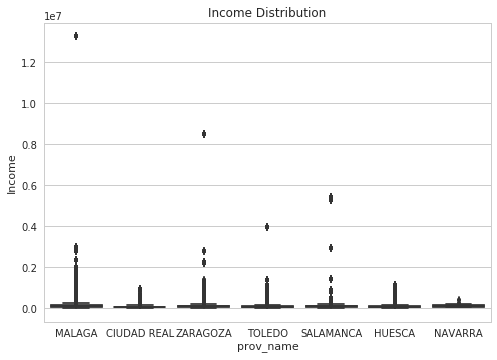

In [78]:
## check income distribution across different provinces
with sns.plotting_context("notebook",font_scale=1.0):
    sns.set_style("whitegrid")
    sns.boxplot(x="prov_name", y="income", 
                data=df.loc[df.prov_name.isin(['MALAGA','ZARAGOZA','SALAMANCA','CIUDAD REAL',
                                                                  'NAVARRA','HUESCA','TOLEDO']), :], palette="PRGn")
    sns.plt.title("Income Distribution")
    plt.ylabel("Income")    

([<matplotlib.axis.YTick at 0x7efba0178210>,
 <a list of 5 Text yticklabel objects>)

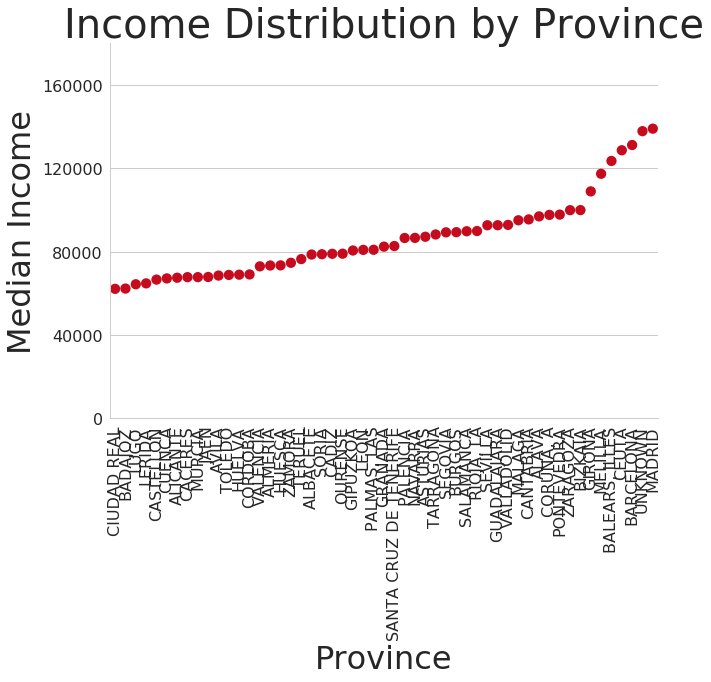

In [79]:
## Check the median income of each province
incomes = df.loc[df.income.notnull(),:].groupby("prov_name").agg({"income":{"MedianIncome":median}})
incomes.sort_values(by=("income","MedianIncome"),inplace=True)
incomes.reset_index(inplace=True)
incomes.prov_name = incomes.prov_name.astype("category", categories=[i for i in df.prov_name.unique()],ordered=False)
#incomes.head()
with sns.plotting_context("notebook",font_scale=1.0):
    h = sns.factorplot(data=incomes,
       x="prov_name",
       y=("income","MedianIncome"),
       order=(i for i in incomes.prov_name),
       size=6,
       aspect=1.5,
       scale=1.0,
       color="#c60b1e",
       linestyles="None")
plt.xticks(rotation=90)
plt.tick_params(labelsize=16)#
plt.ylabel("Median Income",size=32)
plt.xlabel("Province",size=32)
plt.title("Income Distribution by Province",size=40)
plt.ylim(0,180000)
plt.yticks(range(0,180000,40000))


In [80]:
med = df.groupby("prov_name")["income"].transform("median")
df.loc[:,"income"] = df.loc[:,"income"].fillna(med)

In [81]:
df["income"].head()

0     87218.0
1     35548.0
2    122179.0
3    119775.0
4     99950.0
Name: income, dtype: float64

In [82]:
## some income information are missing for entire province
print df.loc[df.income.isnull(), "prov_name"].unique()

[]


In [333]:
## we fill these income with global median
df.loc[:,"income"] = df.loc[:,"income"].fillna(df.loc[:,"income"].median(skipna=True))

- Missing Product purchase information

In [86]:
print df.loc[:, "p22_payroll_appt"].isnull().sum()
print df.loc[:, "p22_payroll_appt"].value_counts()

print df.loc[:, "p23_pensions_appt"].isnull().sum()
print df.loc[:, "p23_pensions_appt"].value_counts()

0
0    12885285
1      745961
0       16063
Name: p22_payroll_appt, dtype: int64
0
0    12821161
1      810085
0       16063
Name: p23_pensions_appt, dtype: int64


In [85]:
## we will fill missing products with zero
df.loc[df.p22_payroll_appt.isnull(), "p22_payroll_appt"] = 0
df.loc[df.p23_pensions_appt.isnull(), "p23_pensions_appt"] = 0

- The rest of cols with missing value

In [87]:
missing_columns = [col for col in df.columns if df[col].isnull().any()]

In [88]:
## unique values for missing cols
for col in missing_columns:
    print("Unique values for {0}:\n{1}\n".format(col,df[col].unique()))

Unique values for idx_employee:
['N' None 'A' 'B' 'F' 'S']

Unique values for country_code:
['ES' None 'CA' 'CH' 'CL' 'IE' 'AT' 'NL' 'FR' 'GB' 'DE' 'DO' 'BE' 'AR' 'VE'
 'US' 'MX' 'BR' 'IT' 'EC' 'PE' 'CO' 'HN' 'FI' 'SE' 'AL' 'PT' 'MZ' 'CN' 'TW'
 'PL' 'IN' 'CR' 'NI' 'HK' 'AD' 'CZ' 'AE' 'MA' 'GR' 'PR' 'RO' 'IL' 'RU' 'GT'
 'GA' 'NO' 'SN' 'MR' 'UA' 'BG' 'PY' 'EE' 'SV' 'ET' 'CM' 'SA' 'CI' 'QA' 'LU'
 'PA' 'BA' 'BO' 'AU' 'BY' 'KE' 'SG' 'HR' 'MD' 'SK' 'TR' 'AO' 'CU' 'GQ' 'EG'
 'ZA' 'DK' 'UY' 'GE' 'TH' 'DZ' 'LB' 'JP' 'NG' 'PK' 'TN' 'TG' 'KR' 'GH' 'RS'
 'VN' 'PH' 'KW' 'NZ' 'MM' 'KH' 'GI' 'SL' 'GN' 'GW' 'OM' 'CG' 'LV' 'LT' 'ML'
 'MK' 'HU' 'IS' 'LY' 'CF' 'GM' 'KZ' 'CD' 'BZ' 'ZW' 'DJ' 'JM' 'BM' 'MT']

Unique values for sex:
['H' 'V' None]

Unique values for date_last_primary:
[None '2015-07-02' '2015-07-23' '2015-07-06' '2015-07-30' '2015-07-20'
 '2015-07-08' '2015-07-22' '2015-07-17' '2015-07-09' '2015-07-03'
 '2015-07-29' '2015-07-13' '2015-07-21' '2015-07-27' '2015-07-14'
 '2015-07-01' '2015-07-2

In [89]:
## Based on the meaning of each variable, fill some with most frequent terms and leave others to be "UNKNOWN"
df.loc[df.idx_decease.isnull(),"idx_decease"] = "N"
df.loc[df.type_cust_relation.isnull(),"type_cust_relation"] = "A"
df.type_cust.fillna("P",inplace=True)
unknown_cols = [col for col in missing_columns if col not in ["idx_decease","type_cust_relation","type_cust"]]
for col in unknown_cols:
    df.loc[df[col].isnull(),col] = "UNKNOWN"

In [90]:
for col in df.columns:
    print col, df.loc[:, col].isnull().sum()

date_record 0
cust_id 0
idx_employee 0
country_code 0
sex 0
age 0
date_first_holder 0
idx_new_cust 0
months_seniority 0
idx_primary 0
date_last_primary 0
type_cust 0
type_cust_relation 0
idx_same_country 0
idx_foreigner 0
idx_spouse 0
channel 0
idx_decease 0
prov_name 0
idx_active 0
income 0
segmentation 0
p1_saving_acct 0
p2_guarantees 0
p3_cur_acct 0
p4_deriv_acct 0
p5_payroll_acct 0
p6_junior_acct 0
p7_mas_paticular_acct 0
p8_particular_acct 0
p9_particular_plus_acct 0
p10_short_depo 0
p11_medium_depo 0
p12_long_depo 0
p13_eacct 0
p14_funds 0
p15_mortgage 0
p16_pensions_plan 0
p17_loans 0
p18_taxes 0
p19_credit_card 0
p20_securities 0
p21_home_acct 0
p22_payroll_appt 0
p23_pensions_appt 0
p24_direct_debit 0
month 0


In [91]:
df.to_csv("../input/train_full_clean.csv", header = True, index = False)

In [93]:
df.to_sql(name='train_sample_clean', con=sq_conn, if_exists='replace', index=False, index_label=None)